## Loading the Dataset and Preprocessing

In [17]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [18]:
import medmnist
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
print(medmnist.__version__)

3.0.2


In [19]:
from medmnist import PneumoniaMNIST,INFO 
from medmnist import INFO



In [20]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [21]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import models, transforms
# torchvision and its modules
import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
# for plotting
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler
# for algebric computations
import numpy as np

In [23]:
#preprocessing: MNIST reference: https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb
data_transform_train = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation([90, 90]),
        transforms.RandomRotation([180, 180]),
        transforms.RandomRotation([270, 270])
    ]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])


train_dataset = PneumoniaMNIST(split="train", download=True, transform=data_transform_train,size=224)
val_dataset = PneumoniaMNIST(split="val", download=True, transform=data_transform,size=224)
test_dataset = PneumoniaMNIST(split="test", download=True, transform=data_transform,size=224)
labels = train_dataset.labels.squeeze()
class_counts = np.bincount(labels)
weights = 1. / class_counts
sample_weights = weights[labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for images, labels in train_loader:
    print("Image batch shape:", images.shape)  # [64, 1, 224, 224] for grayscale
    print("Label batch shape:", labels.shape)  # [64]
    break

#PneumoniaMNIST	Chest X-Ray	Binary-Class (2)	5,856	4,708 / 524 / 624

Using downloaded and verified file: C:\Users\Administrator\.medmnist\pneumoniamnist_224.npz
Using downloaded and verified file: C:\Users\Administrator\.medmnist\pneumoniamnist_224.npz
Using downloaded and verified file: C:\Users\Administrator\.medmnist\pneumoniamnist_224.npz
Image batch shape: torch.Size([64, 1, 224, 224])
Label batch shape: torch.Size([64, 1])


In [24]:

def imshow(img):

    mean = [0.5]
    std = [0.5]
 
    img = img.clone()  
    for t, m, s in zip(img, mean, std):  
        t.mul_(s).add_(m)

    img = img.clamp(0, 1)  
    
   
    npimg = img.permute(1, 2, 0).numpy() 
    plt.imshow(npimg)
    plt.axis('off')  
    plt.show()

torch.Size([1, 224, 224])
Label: [1] 


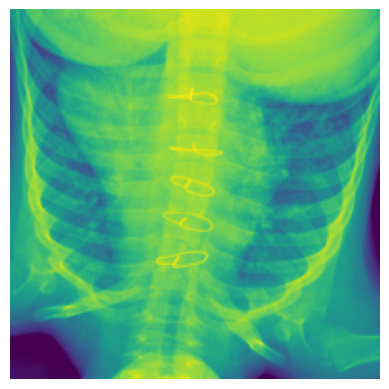

torch.Size([1, 224, 224])
Label: [1] 


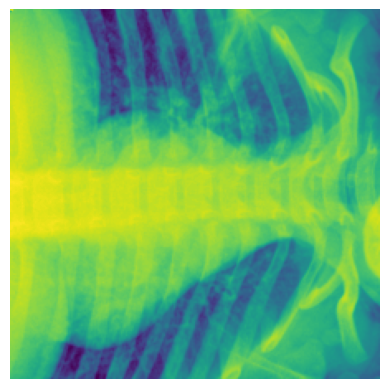

torch.Size([1, 224, 224])
Label: [1] 


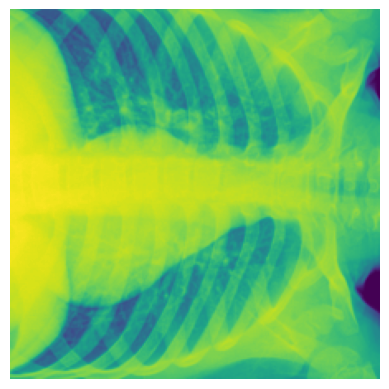

torch.Size([1, 224, 224])
Label: [1] 


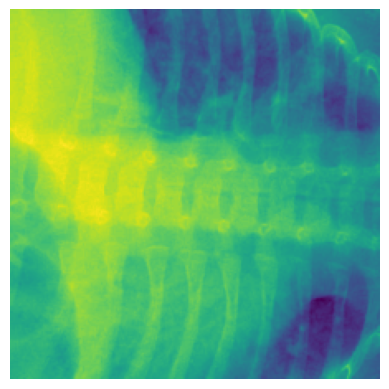

torch.Size([1, 224, 224])
Label: [1] 


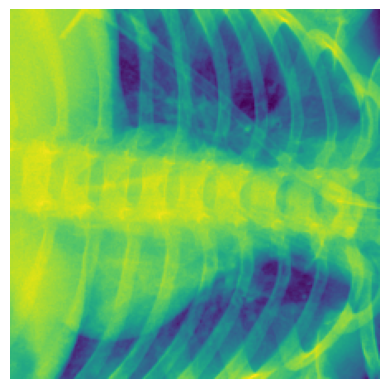

In [25]:

for i in range(5):
    image, label = train_dataset[i]
    print(image.shape)
    print(f"Label: {label} ")
    imshow(image)
 #ALSO ARE THESE THE RIGHT COLORS LOL??

## Building and Testing a CNN Model

In [26]:
unique_labels_train,cout = np.unique(train_dataset.labels,return_counts=True)
unique_labels_val = np.unique(val_dataset.labels)
unique_labels_test = np.unique(test_dataset.labels)

all_unique_labels = np.unique(
    np.concatenate([unique_labels_train, unique_labels_val, unique_labels_test])
)

print(f"Total unique labels in dataset: {len(all_unique_labels)}")
print(f"Unique labels: {all_unique_labels}")
for label, count in zip(unique_labels_train, cout):
    print(f"Label {label}: {count} samples")

Total unique labels in dataset: 2
Unique labels: [0 1]
Label 0: 1214 samples
Label 1: 3494 samples


In [27]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-ce_loss)  
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss

In [28]:
#NEXT STEP, build a CNN model and test. Use VGG16 or smth.
from sklearn.utils.class_weight import compute_class_weight
vgg16 = models.vgg16(pretrained=True)


data_flag = 'pneumoniamnist'
info = INFO[data_flag]
num_classes =len(info['label']) 
vgg16.features[0] = nn.Conv2d(
    in_channels=1,  
    out_channels=64,  
    kernel_size=3,  
    stride=1, 
    padding=1  
)
vgg16.classifier[5] = nn.Dropout(0.5) 
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)
labels = np.array(train_dataset.labels).squeeze()
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)


class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = FocalLoss(alpha=3.0, gamma=2.0).to(device)


#optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = optim.Adam([
    {'params': vgg16.features.parameters(), 'lr': 1e-5},  
    {'params': vgg16.classifier.parameters(), 'lr': 1e-3}  
], weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print(f"Class Weights: {class_weights}")

#the link I sent, uses resnet18. Feel free to use it as guidance.

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class Weights: tensor([1.9390, 0.6737], device='cuda:0')


In [29]:
def train(model, loader, criterion, optimizer, device):
    model.train()  
    total_loss, correct = 0, 0

    for data, targets in tqdm(loader):
     
        data, targets = data.to(device), targets.to(device)
        if targets.ndim > 1:
            targets = targets.squeeze(dim=1)
        targets = targets.long()  
        # forward
        outputs = model(data)
        loss = criterion(outputs, targets)

        # back
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

       
        total_loss += loss.item()
        correct += (outputs.argmax(1) == targets).sum().item()

    
    return total_loss / len(loader), correct / len(loader.dataset)


In [30]:
def test(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device).long()

            targets = targets.squeeze(dim=1).long()  

            outputs = model(data)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == targets).sum().item()

    
            predictions.extend(outputs.argmax(1).cpu().numpy())
            true_labels.extend(targets.cpu().numpy())


    from sklearn.metrics import classification_report, confusion_matrix
    print("Classification Report:\n", classification_report(true_labels, predictions))

    return total_loss / len(loader), correct / len(loader.dataset)



100%|██████████| 74/74 [00:19<00:00,  3.75it/s]


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84       135
           1       0.97      0.91      0.94       389

    accuracy                           0.91       524
   macro avg       0.87      0.91      0.89       524
weighted avg       0.92      0.91      0.91       524

Epoch [1/6]
Train Loss: 0.5903, Train Accuracy: 0.8464
test Loss: 0.0354, test Accuracy: 0.9122


100%|██████████| 74/74 [00:19<00:00,  3.73it/s]


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.85       135
           1       0.98      0.90      0.94       389

    accuracy                           0.91       524
   macro avg       0.87      0.92      0.89       524
weighted avg       0.92      0.91      0.91       524

Epoch [2/6]
Train Loss: 0.0236, Train Accuracy: 0.9261
test Loss: 0.0320, test Accuracy: 0.9122


100%|██████████| 74/74 [00:19<00:00,  3.81it/s]


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86       135
           1       0.97      0.92      0.94       389

    accuracy                           0.92       524
   macro avg       0.89      0.92      0.90       524
weighted avg       0.93      0.92      0.92       524

Epoch [3/6]
Train Loss: 0.0152, Train Accuracy: 0.9397
test Loss: 0.0289, test Accuracy: 0.9198


100%|██████████| 74/74 [00:19<00:00,  3.76it/s]


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.84       135
           1       0.93      0.96      0.95       389

    accuracy                           0.92       524
   macro avg       0.91      0.88      0.89       524
weighted avg       0.92      0.92      0.92       524

Epoch [4/6]
Train Loss: 0.0096, Train Accuracy: 0.9480
test Loss: 0.0257, test Accuracy: 0.9198


100%|██████████| 74/74 [00:19<00:00,  3.81it/s]


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.70      0.78       135
           1       0.90      0.97      0.93       389

    accuracy                           0.90       524
   macro avg       0.89      0.83      0.86       524
weighted avg       0.90      0.90      0.89       524

Epoch [5/6]
Train Loss: 0.0086, Train Accuracy: 0.9503
test Loss: 0.0327, test Accuracy: 0.8989


100%|██████████| 74/74 [00:19<00:00,  3.74it/s]


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       135
           1       0.96      0.95      0.95       389

    accuracy                           0.93       524
   macro avg       0.90      0.91      0.91       524
weighted avg       0.93      0.93      0.93       524

Epoch [6/6]
Train Loss: 0.0061, Train Accuracy: 0.9592
test Loss: 0.0182, test Accuracy: 0.9275


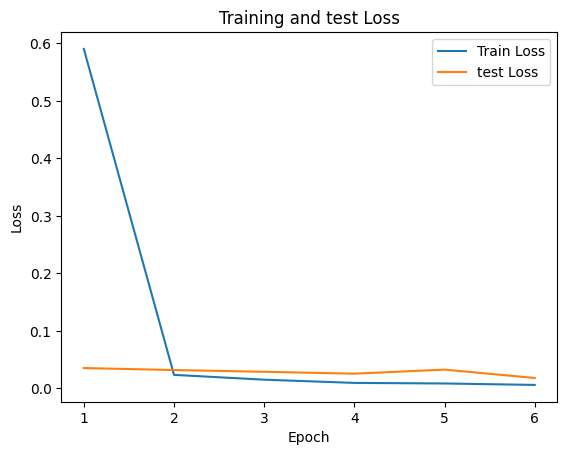

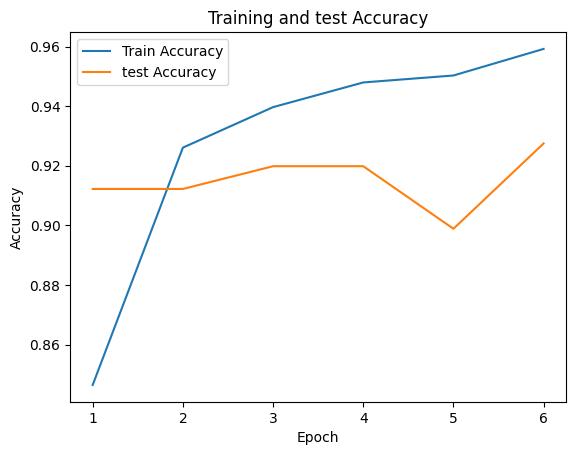

In [31]:
num_epochs = 6
best_accuracy = 0

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # train
    train_loss, train_accuracy = train(vgg16, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = test(vgg16, val_loader, criterion, device)

 
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

   
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"test Loss: {test_loss:.4f}, test Accuracy: {test_accuracy:.4f}")

    # save best epoch
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(vgg16.state_dict(), "best_vgg16_multiclass.pth")
    


    scheduler.step(test_loss)
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and test Loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and test Accuracy')
plt.legend()
plt.show()


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_81860\890041623.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for mor

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.60      0.73       234
           1       0.80      0.97      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.79      0.80       624
weighted avg       0.85      0.83      0.82       624

Test Loss: 0.4376, Test Accuracy: 0.8333
Actual Label: [1]


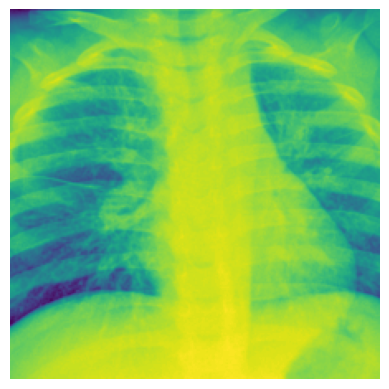

Predicted Label: 1


In [32]:

vgg16 = models.vgg16(pretrained=False)
vgg16.features[0] = nn.Conv2d(
    in_channels=1,  
    out_channels=64,  
    kernel_size=3,  
    stride=1, 
    padding=1  
)
vgg16.classifier[5] = nn.Dropout(0.5) 
vgg16.classifier[6] = torch.nn.Linear(4096, num_classes)

vgg16.eval()
# load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.load_state_dict(torch.load("best_vgg16_multiclass.pth"))
vgg16 = vgg16.to(device)
criterion = torch.nn.CrossEntropyLoss()  
test_loss, test_accuracy = test(vgg16, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
import random

random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]  

print(f"Actual Label: {label}")
imshow(image)
image = image.unsqueeze(0)  # [1, 3, 224, 224]
image = image.to(device)


output = vgg16(image)  
_, predicted = torch.max(output, 1)  # 
print(f"Predicted Label: {predicted.item()}")